In [58]:
import os
import csv
import h5py
from PIL import Image
import numpy as np
from tqdm import tqdm

path = "data"
actions_file = f"{path}/_actions.csv"
time_window = [-0.2, 0.15]  

In [59]:
actions = {}
with open(actions_file, mode='r') as csvfile:
    csvreader = csv.reader(csvfile)
    next(csvreader)  # Skip header
    for row in csvreader:
        run_number, action, timestamp = row
        if run_number not in actions:
            actions[run_number] = []
        actions[run_number].append((float(timestamp), action))
    for run_number in actions:
        actions[run_number].sort() 

In [60]:
def find_actions_in_range(run_number, timestamp):
    if run_number not in actions:
        return ['nothing']
    in_range_actions = set()

    for action_timestamp, action in actions[run_number]:
        if time_window[0] <= timestamp - action_timestamp <= time_window[1]:
            in_range_actions.add(action)

    return list(in_range_actions) if in_range_actions else ['nothing']

In [61]:
from util.my_utils import ACTIONS, ACTION_TO_INDEX, extract_info

image_data = []
labels = []

for filename in tqdm(os.listdir(path), desc="Processing images"):
    if filename.endswith(".png"):
        file_path = os.path.join(path, filename)
        img = Image.open(file_path).convert('RGB')
        img_array = np.array(img)

        run_number, timestamp = extract_info(filename)
        in_range_actions = find_actions_in_range(run_number, float(timestamp))
        label = [0] * len(ACTIONS)
        for action in in_range_actions:
            label[ACTION_TO_INDEX[action]] = 1

        image_data.append(img_array)
        labels.append(label)

Processing images:  71%|███████   | 6106/8652 [03:04<01:16, 33.14it/s]  


In [ ]:
import numpy as np
import h5py
from sklearn.utils import shuffle

image_data = np.array(image_data)
labels = np.array(labels)

not_nothing_indices = np.where(labels[:, 4] == 0)[0] 
nothing_indices = np.where(labels[:, 4] == 1)[0]
nothing_indices = np.random.choice(nothing_indices, int(len(not_nothing_indices) * 0.5), replace=False)

indices = np.concatenate((not_nothing_indices, nothing_indices))
indices = shuffle(indices)

final_image_data = image_data[indices]
final_labels = labels[indices]

with h5py.File('image_data_with_labels.h5', 'w') as hf:
    hf.create_dataset('image_data', data=final_image_data)
    hf.create_dataset('labels', data=final_labels)

print("Balanced HDF5 file created with image data and labels.")

Balanced HDF5 file created with image data and labels.


In [ ]:
print(final_image_data.shape)
print(final_labels.sum(axis=0))

(1665, 620, 1140, 3)
[388 380 196 151 555]


<BarContainer object of 5 artists>

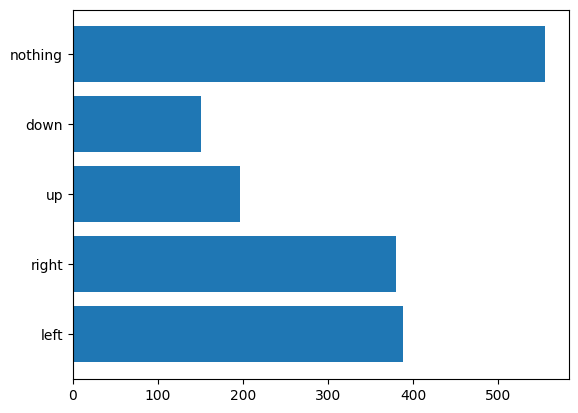

In [ ]:
from matplotlib import pyplot as plt
# barh graph of each label type

plt.barh(list(ACTION_TO_INDEX.keys()), final_labels.sum(axis=0))